<a href="https://colab.research.google.com/github/JR-1991/sysbiojax/blob/master/TestOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Plan

* ✅ Convert datasets into arrays of shape 
  * [Replicate, Time, Species]
* ✅ VMap the simulate function to iterate over each SaveAt and Y0 in parallel
  * Keep Parameters constant!
  * Each measurement has a y0 and timesteps plus data
  * In case of replicates, duplicate y0
* Upon conversion to a tensor, zero-pad data to the maximum array size
  * This addresses varying sample times
  * For beginning, lets stick with constant SaveAt array sizes for now
* Effectively, simulate and calculate residuals simultaneously
  * Jit this for maximum performance!
* Run LMFit as usual, as most of the overhead comes from function evaluation

In [2]:
try:
    from sysbiojax import Model
except ImportError:
    !pip install git+https://github.com/JR-1991/sysbiojax.git

In [30]:
import jax
import jax.numpy as jnp
from jax import config
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters

from typing import List, Dict

config.update("jax_enable_x64", True)

In [4]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1, p0")

# Add ODEs
model.add_ode("s1", "- (kcat * p0 * s1) / ( K_m + s1)")
model.add_ode("p0", "- k * p0")

# Add parameter values
model.parameters.kcat.value = 20
model.parameters.k.value = 0
model.parameters.K_m.value = 200

model

Eq(x, Matrix([[s1, p0]]))

Eq(theta, Matrix([[kcat, K_m, k]]))

Eq(Derivative(s1, t), -kcat*p0*s1/(K_m + s1))

Eq(Derivative(p0, t), -k*p0)

(4, 21)

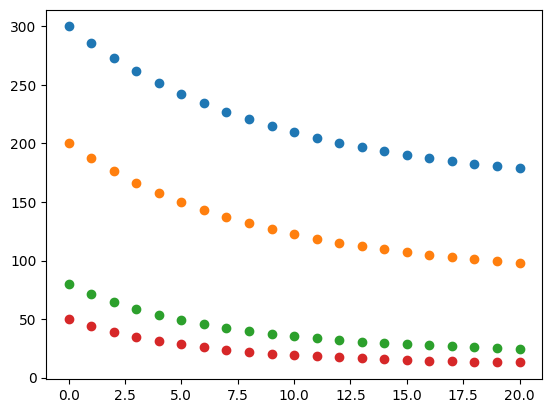

In [28]:
# Generate irregular time series data generated
# from a simple menten model

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
time = jnp.tile(jnp.arange(21), 4).reshape(4, 21)

# Set initial conditions above and below the
# true Km value for the sake of the example
initial_conditions = [
    {"s1": 300.0, "p0": 1},
    {"s1": 200.0, "p0": 1},
    {"s1": 80.0, "p0": 1},
    {"s1": 50.0, "p0": 1},
]

# K_m, k, kcat
params = jnp.array([100, 0.1, 20])

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1,
    saveat=time,
    parameters=params,
    in_axes=(0, None, 0),
)

substrate_measurements = data[:, :, 1]


for t, d in zip(time, substrate_measurements):
    plt.scatter(t, d)

substrate_measurements.shape

In [20]:
def create_lmfit_params(parameter_list: List[str]):
    params = Parameters()
    [params.add(name=name) for name in parameter_list]
    return params

In [66]:
# fcn(params, *args, **kws)


def residuals(
    params: Parameters,
    model: Model,
    time: jax.Array,
    data: jax.Array,
    initial_conditions: List[Dict[str, float]],
    dt0: float,
):
    params_dict = params.valuesdict()
    sorted_keys = sorted(list(params_dict.keys()))
    parameters = jnp.array([params_dict[key] for key in sorted_keys])

    sim_time, sim_data = model.simulate(
        initial_conditions=initial_conditions,
        dt0=dt0,
        saveat=time,
        parameters=parameters,
        in_axes=(0, None, 0),
    )

    return sim_data - data

In [67]:
# define lmfit parameters
lmfit_params = create_lmfit_params(model.parameters)
lmfit_params["kcat"].value = 19
lmfit_params["K_m"].value = 99
lmfit_params["k"].value = 0.15

In [71]:
# test residuals function
res = residuals(
    params=lmfit_params,
    model=model,
    time=time,
    data=data,
    dt0=0.1,
    initial_conditions=initial_conditions,
)

# res

In [75]:
result = lmfit.minimize(
    fcn=residuals,
    params=lmfit_params,
    kws={
        "model": model,
        "time": time,
        "data": data,
        "dt0": 0.1,
        "initial_conditions": initial_conditions,
    },
)

result

In [ ]:
# TODO - write 'residuals' function for parameter estimation

In [ ]:
# TODO - write LMFit wrapper for parameter estimation

In [ ]:
# TODO - Write a function that takes a model and a dataset and returns a fitted model

In [ ]:
# TODO - Write a measurement class that wraps data and provides it to the fitting function